In [6]:
from datasets import load_dataset
import pandas as pd
import logging
import time
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain_groq import ChatGroq
import os
from langchain_cohere import ChatCohere

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from IPython.display import display, HTML
import json

TypeError: cannot pickle 'classmethod' object

In [2]:
file_path = 'pes_arab_dataset.csv'  # Path for the CSV file
data = pd.read_csv(file_path)

# Sample 50 entries from the dataset
sampled_data = data.sample(n=5, random_state=42)

sampled_data

,link,question_number,flores_passage,question,mc_answer1,mc_answer2,mc_answer3,mc_answer4,correct_answer_num,dialect,ds
70,https://en.wikibooks.org/wiki/High_School_Eart...,1,بشر هزاران هزار سال از عدسی‌ها برای بزرگ‌نمایی...,کدام یک از موارد زیر را انسان‌ها در قرن شانزده...,استفاده از عدسی‌ها,بزرگنمایی اشیاء,ساخت عدسی‌ها,ساخت تلسکوپ,4,pes_Arab,2023-06-07
827,https://en.wikivoyage.org/wiki/Paraguay,1,گوارانی‌ها مهم‌ترین گروه بومی ساکن پاراگوئه شر...,دوران استعمارگری که سه قرن طول کشید توسط کدام ...,پاراگوئه,Guaycurú,گورانی‌ها,فاتحان اسپانیایی,4,pes_Arab,2023-06-07
231,https://en.wikibooks.org/wiki/Wikijunior:Solar...,2,خورشید پوسته‌ای شبیه کره زمین ندارد که بتوانید...,با توجه به متن، کدام قسمت از خورشید از زمین قا...,پوسته,پلاسما,فوتوسفر,مرکز,3,pes_Arab,2023-06-07
588,https://en.wikinews.org/wiki/Seven_killed_in_C...,2,آن مرد ظاهراً یک خودروی سه‌چرخ مسلح به مواد من...,مقامات چه اطلاعاتی درخصوص حمله تأیید کرده بودند؟,هویت هم‌دست‌ها,قومیت مظنون,انگیزه حمله,نام و نام خانوادگی مظنون,2,pes_Arab,2023-06-07
39,https://en.wikibooks.org/wiki/Environmental_th...,1,ما می توانیم زندگی دوستانه تری را با محیط زیست...,با توجه به متن، کدام مورد راه‌حلی قابل اجرا بر...,تحریم انتخاب‌های سبک زندگی مصرف‌گرایانه,کنشگری,یافتن ریشه مسئله,تبدیل شدن به متحد جنبش محیط زیست,3,pes_Arab,2023-06-07


In [18]:
os.environ['GROQ_API_KEY'] = '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'

# Chunk data

In [4]:
def split_into_chunks(df, chunk_size):
    """
    Splits a DataFrame into chunks of a specified size.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to split.
        chunk_size (int): The number of rows per chunk.
    
    Returns:
        list: A list of DataFrames, each containing up to `chunk_size` rows.
    """
    chunks = [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
    return chunks

# Example usage
import pandas as pd

# Load your dataset
file_path = 'pes_arab_dataset.csv'
data = pd.read_csv(file_path)

# Split into chunks of 100 rows
chunk_size = 300
chunks = split_into_chunks(data, chunk_size)

# Save each chunk as a separate file
for i, chunk in enumerate(chunks):
    output_file = f"chunk_{i + 1}.csv"
    chunk.to_csv(output_file, index=False)
    print(f"Saved: {output_file}")

Saved: chunk_1.csv
Saved: chunk_2.csv
Saved: chunk_3.csv


In [5]:
chunk_1_data = pd.read_csv('chunk_1.csv')
chunk_2_data = pd.read_csv('chunk_2.csv')
chunk_3_data = pd.read_csv('chunk_3.csv')

# Use model

In [10]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Function to check the API with custom parameters: model_name and temperature
def check_api_with_parameters(model_name, temperature):
    """
    Initialize the ChatGroq model with the specified parameters.
    """
    llm = ChatGroq(
        model=model_name,
        temperature=temperature,
        max_tokens=None,  # No limit on the number of tokens
        timeout=None,     # Use default timeout
        max_retries=2     # Retry failed requests twice
    )
    return llm

# Function to predict the answer and save the full generation to a file
def predict_answer_and_save(passage, question, options, llm, generation_file):
    """
    Predict the answer and save the response and explanation to a file.
    """
    logging.info(f"Starting prediction for passage: {passage[:50]}... and question: {question}")
    try:
        # Define the messages for ChatGroq
        messages = [
            {
                "role": "system",
                "content": (
                    "You will receive a `QUESTION` with multiple `ANSWER CHOICES` and a supporting `CONTEXT`. "
                    "Your task is to determine the correct answer based on the information in the context and to explain "
                    "your reasoning step-by-step, referencing key details from the context.\n\n"
                    "Follow these instructions for your response:\n\n"
                    "Select only one answer choice (1, 2, 3, or 4) based on your understanding of the context.\n"
                    "   - Format: <answer>[Your CHOICE here]</answer>\n\n"
                    "Provide a detailed, step-by-step explanation of how you arrived at the answer, focusing on the logical reasoning process. "
                    "Include references to relevant parts of the context to support each reasoning step. `The explanation must be in Persian.`\n"
                    "   - Format: <explanation>[Step-by-step reasoning and references to context here]</explanation>\n\n"
                    "Identify and quote the most relevant parts of the context that were essential in answering the question. "
                    "Only include the specific information that directly supports your chosen answer. `Ensure this is in Persian.`\n"
                    "   - Format: <highlight>[Key supporting context here]</highlight>\n\n"
                    "List the most important keywords from the context that are essential for understanding and answering the question. "
                    "`Provide keywords as a Python list, in Persian.`\n"
                    "   - Format: <keywords>[Relevant KEYWORDS here]</keywords>\n\n"
                    "---\n\n"
                    "`Guidelines for Self-Explanation`:\n"
                    "- Make sure your explanation is complete, covering all reasoning steps used to reach the answer.\n"
                    "- Ensure your reasoning is relevant and directly tied to the context, avoiding any unrelated details.\n"
                    "- Keep the explanation clear and logical, with each step following naturally from the previous one.\n"
                    "- Reflect the information in the context faithfully, without adding unsupported assumptions."
                )
            },
            {
                "role": "user",
                "content": (
                    f"CONTEXT:\n{passage}\n\n"
                    f"QUESTION:\n{question}\n\n"
                    f"ANSWER CHOICES:\n1-{options[0]}\n2-{options[1]}\n3-{options[2]}\n4-{options[3]}"
                )
            }
        ]

        # Invoke the Groq model
        result = llm.invoke(messages)

        # Save the result to a file
        with open(generation_file, "a", encoding="utf-8") as f:
            json.dump({
                "Passage": passage,
                "Question": question,
                "Options": options,
                "ModelResponse": result.content.strip()
            }, f, ensure_ascii=False)
            f.write("\n")

        logging.info(f"Full generation saved for parsing: {result.content.strip()}")
        return result.content.strip()
    except Exception as e:
        logging.error(f"Error in predict_answer_and_save: {e}")
        return "error"

# Retry function with exponential backoff
def make_request_with_retry(func, *args, retries=3, delay=10):
    """
    Retry a function call with exponential backoff.
    """
    for attempt in range(retries):
        try:
            return func(*args)
        except ConnectionError as e:
            logging.warning(f"Attempt {attempt + 1} failed: {e}. Retrying in {delay} seconds...")
            time.sleep(delay)
            delay *= 2  # Exponential backoff
    logging.error("Max retries exceeded.")
    raise ConnectionError("Max retries exceeded.")

# Function to apply predictions to a dataset and save results
def apply_prediction_and_save(df, model_name, temperature, generation_file="model_generations.json", mode="just_predict", result_name="sample"):
    """
    Apply predictions to each row in the dataset and save the results.
    """
    llm = check_api_with_parameters(model_name, temperature)

    results = []

    for index, row in df.iterrows():
        passage = row['flores_passage']
        question = row['question']
        options = [row['mc_answer1'], row['mc_answer2'], row['mc_answer3'], row['mc_answer4']]
        original_answer = row['correct_answer_num']

        logging.info(f"Processing row {index + 1}/{len(df)}: {passage[:50]}...")

        # Predict answer with retry
        if mode == "just_predict":
            predicted_answer = make_request_with_retry(predict_answer_and_save, passage, question, options, llm, generation_file)
            time.sleep(10)
        else:
            logging.error(f"Invalid mode: {mode}")
            predicted_answer = "error"

        # Store the result
        results.append({
            "Passage": passage,
            "Question": question,
            "Original Answer": original_answer,
            "Predicted Answer": predicted_answer,
            "Option 1": options[0],
            "Option 2": options[1],
            "Option 3": options[2],
            "Option 4": options[3]
        })

        logging.info(f"Row {index + 1} processed successfully.")

    # Save all results to a DataFrame
    result_df = pd.DataFrame(results)
    output_file_name = result_name + ".csv"
    result_df.to_csv(output_file_name, index=False)
    logging.info(f"Results saved to {output_file_name}")

    return result_df

In [11]:
# Apply predictions
apply_prediction_and_save(chunk_1_data, model_name="llama3-70b-8192", temperature=0.3, result_name='part_1')

2025-01-24 05:40:52,100 - Processing row 1/300: بسیاری، ریتم‌های فیزیولوژی و رفتار را غالباً به صو...
2025-01-24 05:40:52,106 - Starting prediction for passage: بسیاری، ریتم‌های فیزیولوژی و رفتار را غالباً به صو... and question: کدام یک از موارد زیر علیرغم وجود نشانه‌های خارجی ادامه پیدا خواهد کرد؟
2025-01-24 05:41:13,206 - Retrying request to /openai/v1/chat/completions in 0.888668 seconds
2025-01-24 05:42:39,270 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-24 05:42:39,272 - Full generation saved for parsing: <answer>3</answer>

<explanation>
برای پاسخ به این سوال، باید به تعریف ساعت‌های بیولوژیکی در متن توجه کنیم. در متن گفته شده است که ساعت‌های بیولوژیکی نوسان‌سازهای خودپایداری هستند که دوره‌ای از یک سیکل آزاد‌گرد را در نبود نشانه‌های بیرونی ادامه می‌دهند. این تعریف نشان می‌دهد که ساعت‌های بیولوژیکی حتی در نبود نشانه‌های خارجی نیز ادامه پیدا می‌کنند. بنابراین، گزینه ۳ صحیح است.

در گزینه ۱، چرخه درون‌زا ممکن است در حضور نشانه‌های خار

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4
0,بسیاری، ریتم‌های فیزیولوژی و رفتار را غالباً ب...,کدام یک از موارد زیر علیرغم وجود نشانه‌های خار...,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,چرخه درون‌زا,ریتم‌های دوره‌ای,ساعت‌های بیولوژیک,ریتم‌های مشاهده‌شده
1,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام واژه افرادی را توصیف می‌کند که چندین نوع ...,4,<answer>4</answer>\n\n<explanation>\nبرای پاسخ...,تک‌شکل,ارگانیسم‌ها,گونه‌ها,چند شکلی
2,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام مورد اصطلاح صحیح برای ارگانیسم‌هایی است ک...,2,<answer>2</answer>\n\n<explanation>\nبرای پاسخ...,تک‌شکل,جمعیت,گونه‌ها,چند شکلی
3,جهانگردی طبیعت‌دوست به جذب افراد علاقه‌مند به ...,کدام یک از موارد زیر مثالی از گردشگری طبیعت‌دو...,3,<answer>4</answer>\n\n<explanation>\nبرای پاسخ...,پیاده‌روی تا آبشار,عکسبرداری از گل‌های وحشی,بازدید از موزه‌های علوم,ماهیگیری با حشره مصنوعی
4,هر روز صبح، مردم شهرهای کوچک شهرستان را با اتو...,با توجه به متن، کدام یک از موارد زیر مبنای سیس...,2,<answer>2</answer>\n\n<explanation>\nبرای پاسخ...,مقاصد کاری,اتومبیل‌های شخصی,بیوسفر پایدار,تکامل انسان
...,...,...,...,...,...,...,...,...
295,مدیر عامل اپل «استیو جابز» دستگاه را با رفتن س...,هدف از سخنرانی دو ساعته «استیو جابز» چه بود؟,3,<answer>3</answer>\n\n<explanation>\nهدف از سخ...,رونمایی تبلت جدید,رونمایی کامپیوتر جدید,رونمایی تلفن جدید,اعلام بازنشستگی خود
296,سناتور فعلی و بانوی اول آرژانتین، کریستینا الی...,کریستینا فرناندز دی کرشنر در تئاتر آرژانتین چه...,1,<answer>1</answer>\n\n<explanation>\nبرای پاسخ...,کاندیداتوری خود برای ریاست جمهوری,قصدش برای شرکت در انتخابات سنا,کارزار او برای نمایندگی استان بوئنوس آیرس,برنامه وی برای کناره‌گیری از منصب فعلی به عنوا...
297,سناتور فعلی و بانوی اول آرژانتین، کریستینا الی...,کریستینا فرناندز دی کرشنر قصد خود برای نامزدی ...,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,در تئاتری در 31 مایلی لا پلاتا,در تئاتر بوئنوس آیرس در لا پلاتا,در تئاتر آرژانتین در 31 مایلی بوئنوس آیرس,در تئاتر لا پلاتا در بوئنوس آیرس
298,ACMA همچنین نتیجه گرفت که علیرغم اینکه این وید...,یافته‌های ACMA در رابطه با Big Brother چه بود؟,1,<answer>1</answer>\n\n<explanation>\nبرای پاسخ...,قوانین سانسور نقض نشده بود,مشخص شد که رسانه در وب‌سایت Big Brother ذخیره ...,قوانین سانسور نقض شده بود,مشخص شد که محتوا به صورت فیزیکی در یک سرور قرا...


In [14]:
# Apply predictions
apply_prediction_and_save(chunk_2_data, model_name="llama3-70b-8192", temperature=0.3, result_name='part_2')

2025-01-24 11:49:45,270 - Processing row 1/300: پیتر کاستلو، خزانه دار استرالیایی و مردی که به احت...
2025-01-24 11:49:45,270 - Starting prediction for passage: پیتر کاستلو، خزانه دار استرالیایی و مردی که به احت... and question: رهبر حزب لیبرال استرالیا کیست؟
2025-01-24 11:49:46,718 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-24 11:49:46,817 - Full generation saved for parsing: <answer>1</answer>

<explanation>
با توجه به متن، پیتر کاستلو به عنوان مردی که به احتمال زیاد به عنوان رهبر حزب لیبرال جانشین نخست وزیر جان هاوارد می‌شود، معرفی شده است. این جمله به وضوح نشان می‌دهد که پیتر کاستلو احتمالاً رهبر حزب لیبرال خواهد شد. بنابراین، پاسخ صحیح گزینه ۱، پیتر کاستلو است.
</explanation>

<highlight>
«مردی که به احتمال زیاد به عنوان رهبر حزب لیبرال جانشین نخست وزیر جان هاوارد می‌شود»
</highlight>

<keywords>['پیتر کاستلو', 'رهبر حزب لیبرال', 'جان هاوارد', 'استرالیا']</keywords>
2025-01-24 11:49:56,822 - Row 1 processed successfully.
2025-01-

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4
0,پیتر کاستلو، خزانه دار استرالیایی و مردی که به...,رهبر حزب لیبرال استرالیا کیست؟,2,<answer>1</answer>\n\n<explanation>\nبا توجه ب...,پیتر کاستلو,جان هاوارد,جان کر,مالکولم فراسر
1,پیتر کاستلو، خزانه دار استرالیایی و مردی که به...,چرا استرالیا پیش از این صنعت انرژی هسته‌ای ندا...,4,<answer>4</answer>\n\n<explanation>\nبا توجه ب...,عدم پشتیبانی عمومی,بیش از اندازه جنجالی بودن,بیش از اندازه خطرناک بودن,بیش از اندازه گران بودن
2,از آنجایی که فقط هجده مدال در روز وجود دارد، ب...,کدام اسکی باز با کمک راهنما مسابقه داد؟,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,آنا جاشمسن,پارک سئورک جونگ,ماسیج کرزل,آنا اوگارزینسکا
3,از آنجایی که فقط هجده مدال در روز وجود دارد، ب...,کدام کشور در مسابقات Super-G کلاس ایستاده زنان...,1,<answer>None of the above</answer>\n\n<explana...,فنلاند,هلند,استرالیا,مکزیک
4,محاکمه در دادگاه کراون برمینگام انجام گرفت و ر...,با توجه به متن، کدام جمله درباره بلیک صحیح نیست؟,2,<answer>2</answer>\n\n<explanation>\nبرای پاسخ...,در صحنه جرم دستگیر شد,به حمله اعتراف کرد,هنگام حمله از یک میله استفاده کرد,مدعی شد که به سمت او بطری پرتاب شده است
...,...,...,...,...,...,...,...,...
295,ویدال 28 ساله سه فصل پیش از باشگاه سِویا به با...,مطابق متن، ویدال در سه فصل گذشته در کدام باشگا...,3,<answer>1</answer>\n\n<explanation>\nبرای پاسخ...,سِویا,کاتالونیا,بارسا,کاپیتال
296,ویدال 28 ساله سه فصل پیش از باشگاه سِویا به با...,ویدال چند بازی برای بارسا انجام داده است؟,1,<answer>1</answer>\n\n<explanation>\nبرای پاسخ...,49,39,3,29
297,Jarque در اوایل همان روز مشغول تعلیم‌های قبل ا...,حریف در مسابقه چه تیمی بود؟,2,<answer>2</answer>\n\n<explanation>\nبرای پاسخ...,Jarque,بولونیا,Coverciano,Italy
298,Jarque در اوایل همان روز مشغول تعلیم‌های قبل ا...,چرا Jarque در هتل ماند؟,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,او تمرین داشت,او یک جلسه قبل از فصل داشت,او یکشنبه یک مسابقه داشت,او با بولونیا تمرین می‌کرد


In [19]:
# Apply predictions
apply_prediction_and_save(chunk_3_data, model_name="llama3-70b-8192", temperature=0.3, result_name='part_3')

2025-01-24 13:43:22,414 - Processing row 1/300: هیچ هشدار سونامی اعلام نشده است و طبق آژانس ژئوفیز...
2025-01-24 13:43:22,415 - Starting prediction for passage: هیچ هشدار سونامی اعلام نشده است و طبق آژانس ژئوفیز... and question: مطابق با متن، زمین‌لرزه سبب چه شد؟
2025-01-24 13:43:25,160 - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-24 13:43:25,160 - Full generation saved for parsing: <answer>4</answer>

<explanation>
برای پاسخ به این سوال، ابتدا باید به متن توجه کنیم. متن می‌گوید که زمین لرزه با شدت 6.5 ریشتر رخ داده است. سپس می‌گوید که هیچ هشدار سونامی اعلام نشده است و علت آن این است که زمین لرزه با شرط شدت 6.5 ریشتر همخوانی نداشت. پس از آن، متن می‌گوید که ساکنین وحشت‌زده شدند و کسب و کار و خانه‌هایشان را ترک کردند.

با توجه به متن، می‌توانیم بفهمیم که زمین لرزه به بزرگی 6.5 ریشتر رخ داده است و این زمین لرزه سبب وحشت محلی‌ها شده است. اما سوال می‌پرسد که زمین لرزه سبب چه شد؟ در اینجا، باید به قسمت اول متن توجه کنیم که می‌گوید زمین لرزه ر

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4
0,هیچ هشدار سونامی اعلام نشده است و طبق آژانس ژئ...,مطابق با متن، زمین‌لرزه سبب چه شد؟,1,<answer>4</answer>\n\n<explanation>\nبرای پاسخ...,وحشت محلی‌ها,خطر سونامی,صدور هشدار,زمین‌لرزه به بزرگی 6.5 ریشتر
1,آنها دریافتند که خورشید بر اساس همان اصول اساس...,کدام‌یک از این موارد سبب فعالیت خورشید و ستاره...,3,<answer>1</answer>\n\n<explanation>\nبرای پاسخ...,توان تابشی و جریان پلاسما,عدد روسبی، چرخش و واژگونی مغناطیسی,چرخش و توان تابشی,توان تابشی، عدد روسبی و چرخش
2,آنها دریافتند که خورشید بر اساس همان اصول اساس...,عدد روسبی ستاره چطور تعیین می‌شود؟,1,<answer>1</answer>\n\n<explanation>\nبرای پاسخ...,توان تابشی و چرخش,میزان جریان پلاسما,سطح فعالیت,میزان وارونگی مغناطیسی
3,"از بین 1,400 نفری که قبل از انتخابات فدرال 201...",چند درصد از افراد نظرسنجی‌شده از جمهوری شدن فو...,2,<answer>2</answer>\n\n<explanation>\nبرای پاسخ...,31 درصد,29 درصد,8 درصد,34 درصد
4,"از بین 1,400 نفری که قبل از انتخابات فدرال 201...",مطابق با Julie Gillard، استرالیا چه زمانی باید...,2,<answer>2</answer>\n\n<explanation>\nبر اساس م...,در اسرع وقت,پس از کناره‌گیری ملکه الیزابت دوم,هیچ‌وقت,پس از انتخابات فدرال
...,...,...,...,...,...,...,...,...
295,قالب‌های بسیار مختلفی از فیلم وجود دارد که طی ...,کدام‌یک از قالب‌های فیلم وضوح تصویری ارائه می‌...,1,<answer>1</answer>\n\n<explanation>\nبرای یافت...,فیلم 35 میلی‌متری,فیلم با قالب متوسط,فیلم 56 در 56 میلی‌متر,فیلم 6 در 6 سانتی‌متر
296,ساده ترین راه برای شروع کار در زمینه سفرنامه ن...,مطابق با این متن، کدام‌یک از این موارد آخرین م...,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,تمرین فرمت‌بندی وب,نوشتن مقالات متعدد برای یک وبلاگ مسافرتی سرشناس,ساخت وب‌سایت خودتان,بهبود بخشیدن مهارت‌های ویرایشتان
297,ساده ترین راه برای شروع کار در زمینه سفرنامه ن...,هنگام شروع یک کار سفرنامه‌نویسی، کدام‌یک از فع...,1,<answer>1</answer>\n\n<explanation>\nبرای شروع...,وبلاگ‌نویسی,فرمت‌بندی وب,ویرایش,ایجاد وب‌سایت
298,در خانه بدلیل قرارگیری مداوم در معرض میکروب‌ها...,مشکلات گوارشی معمولاً در چه نوع آب‌وهوایی یافت...,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,آب‌وهوای سرد,آب‌وهوای قطبی,آب‌وهوای گرم,آب‌وهوای خشک


In [20]:
# List of file paths (replace these with your actual file paths)
file_paths = ["part_1.csv", "part_2.csv", "part_3.csv"]

# Load and concatenate the files into a single DataFrame
merged_df = pd.concat([pd.read_csv(file) for file in file_paths], ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv("merged_chunks.csv", index=False)

print("Merged DataFrame saved as 'merged_chunks.csv'.")

Merged DataFrame saved as 'merged_chunks.csv'.


In [21]:
rs_df = pd.read_csv('merged_chunks.csv')
rs_df

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4
0,بسیاری، ریتم‌های فیزیولوژی و رفتار را غالباً ب...,کدام یک از موارد زیر علیرغم وجود نشانه‌های خار...,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,چرخه درون‌زا,ریتم‌های دوره‌ای,ساعت‌های بیولوژیک,ریتم‌های مشاهده‌شده
1,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام واژه افرادی را توصیف می‌کند که چندین نوع ...,4,<answer>4</answer>\n\n<explanation>\nبرای پاسخ...,تک‌شکل,ارگانیسم‌ها,گونه‌ها,چند شکلی
2,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام مورد اصطلاح صحیح برای ارگانیسم‌هایی است ک...,2,<answer>2</answer>\n\n<explanation>\nبرای پاسخ...,تک‌شکل,جمعیت,گونه‌ها,چند شکلی
3,جهانگردی طبیعت‌دوست به جذب افراد علاقه‌مند به ...,کدام یک از موارد زیر مثالی از گردشگری طبیعت‌دو...,3,<answer>4</answer>\n\n<explanation>\nبرای پاسخ...,پیاده‌روی تا آبشار,عکسبرداری از گل‌های وحشی,بازدید از موزه‌های علوم,ماهیگیری با حشره مصنوعی
4,هر روز صبح، مردم شهرهای کوچک شهرستان را با اتو...,با توجه به متن، کدام یک از موارد زیر مبنای سیس...,2,<answer>2</answer>\n\n<explanation>\nبرای پاسخ...,مقاصد کاری,اتومبیل‌های شخصی,بیوسفر پایدار,تکامل انسان
...,...,...,...,...,...,...,...,...
895,قالب‌های بسیار مختلفی از فیلم وجود دارد که طی ...,کدام‌یک از قالب‌های فیلم وضوح تصویری ارائه می‌...,1,<answer>1</answer>\n\n<explanation>\nبرای یافت...,فیلم 35 میلی‌متری,فیلم با قالب متوسط,فیلم 56 در 56 میلی‌متر,فیلم 6 در 6 سانتی‌متر
896,ساده ترین راه برای شروع کار در زمینه سفرنامه ن...,مطابق با این متن، کدام‌یک از این موارد آخرین م...,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,تمرین فرمت‌بندی وب,نوشتن مقالات متعدد برای یک وبلاگ مسافرتی سرشناس,ساخت وب‌سایت خودتان,بهبود بخشیدن مهارت‌های ویرایشتان
897,ساده ترین راه برای شروع کار در زمینه سفرنامه ن...,هنگام شروع یک کار سفرنامه‌نویسی، کدام‌یک از فع...,1,<answer>1</answer>\n\n<explanation>\nبرای شروع...,وبلاگ‌نویسی,فرمت‌بندی وب,ویرایش,ایجاد وب‌سایت
898,در خانه بدلیل قرارگیری مداوم در معرض میکروب‌ها...,مشکلات گوارشی معمولاً در چه نوع آب‌وهوایی یافت...,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,آب‌وهوای سرد,آب‌وهوای قطبی,آب‌وهوای گرم,آب‌وهوای خشک


# Parse Result

In [22]:
import re

# Function to clean up and normalize Persian text encoding issues
def clean_text(text):
    if text:
        return text.replace('\u200c', '')  # Replace zero-width non-joiners and any encoding artifacts
    return text

# Updated parsing function with robust handling for variations
def parse_prediction(prediction_text):
    # Clean text first to ensure consistency in encoding
    prediction_text = clean_text(prediction_text)
    
    # Patterns to handle different formats and extract components
    answer_pattern = re.compile(r"<answer>(.*?)</answer>|Answer: (\d)", re.DOTALL)
    explanation_pattern = re.compile(r"<(?:explanation|self-explanation)>(.*?)</(?:explanation|self-explanation)>", re.DOTALL)
    highlight_pattern = re.compile(r"<highlight(?:ed)?>\s*(.*?)\s*</highlight(?:ed)?>", re.DOTALL)
    keywords_pattern = re.compile(r"<keywords>\s*\[(.*?)\]\s*</keywords>", re.DOTALL)

    # Extract answer choice, handle possible formats
    answer_match = answer_pattern.search(prediction_text)
    answer = answer_match.group(1).strip() if answer_match and answer_match.group(1) else None

    # Extract explanation with variations
    explanation_match = explanation_pattern.search(prediction_text)
    explanation = explanation_match.group(1).strip() if explanation_match else None

    # Extract highlighted context with variations
    highlight_match = highlight_pattern.search(prediction_text)
    highlight = highlight_match.group(1).strip() if highlight_match else None

    # Extract keywords as a list
    keywords_match = keywords_pattern.search(prediction_text)
    keywords = [k.strip() for k in keywords_match.group(1).split(",")] if keywords_match else []
    
    return {
        "Parsed Answer": answer,
        "Parsed Explanation": explanation,
        "Parsed Highlighted Context": highlight,
        "Parsed Keywords": keywords
    }

In [23]:
# Apply the parsing function to the 'Predicted Answer' column and expand into new columns
parsed_columns = rs_df['Predicted Answer'].apply(parse_prediction).apply(pd.Series)

# Concatenate the parsed columns with the original DataFrame
df = pd.concat([rs_df, parsed_columns], axis=1)

In [28]:
df['Parsed Answer'].value_counts()

Parsed Answer
2                    242
3                    225
1                    222
4                    200
4-شوالیهها             1
4-اسپانیا              1
3-ملخها                1
None of the above      1
3-تراکم زیاد           1
5                      1
Name: count, dtype: int64

In [ ]:
filter_df = df[df['Predicted Answer'] != 'error']

In [34]:
error_df = df[df['Predicted Answer'] == 'error']

In [33]:
filter_df

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4,Parsed Answer,Parsed Explanation,Parsed Highlighted Context,Parsed Keywords
0,بسیاری، ریتم‌های فیزیولوژی و رفتار را غالباً ب...,کدام یک از موارد زیر علیرغم وجود نشانه‌های خار...,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,چرخه درون‌زا,ریتم‌های دوره‌ای,ساعت‌های بیولوژیک,ریتم‌های مشاهده‌شده,3,برای پاسخ به این سوال، باید به تعریف ساعتهای ب...,ساعتهای بیولوژیکی نوسانسازهای خودپایداری هستند...,"['ساعتهای بیولوژیکی', 'نوسانسازهای خودپایداری'..."
1,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام واژه افرادی را توصیف می‌کند که چندین نوع ...,4,<answer>4</answer>\n\n<explanation>\nبرای پاسخ...,تک‌شکل,ارگانیسم‌ها,گونه‌ها,چند شکلی,4,برای پاسخ به این سوال، ابتدا باید مفهوم جمعیت ...,«هنگامی که افراد چندین نوع ویژگی خاص را نشان م...,"['جمعیت', 'تکشکل', 'چند شکلی', 'خصوصیت فنوتیپی']"
2,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام مورد اصطلاح صحیح برای ارگانیسم‌هایی است ک...,2,<answer>2</answer>\n\n<explanation>\nبرای پاسخ...,تک‌شکل,جمعیت,گونه‌ها,چند شکلی,2,برای پاسخ به این سوال، ابتدا باید معنی هر کدام...,جمعیت عبارت است از مجموعهای از موجودات زنده یک...,"[""جمعیت"", ""منطقه جغرافیایی"", ""ارگانیسمها"", ""فض..."
3,جهانگردی طبیعت‌دوست به جذب افراد علاقه‌مند به ...,کدام یک از موارد زیر مثالی از گردشگری طبیعت‌دو...,3,<answer>4</answer>\n\n<explanation>\nبرای پاسخ...,پیاده‌روی تا آبشار,عکسبرداری از گل‌های وحشی,بازدید از موزه‌های علوم,ماهیگیری با حشره مصنوعی,4,برای پاسخ به این سوال، باید به هدف جهانگردی طب...,جهانگردی طبیعتدوست به جذب افراد علاقهمند به با...,"['جهانگردی طبیعتدوست', 'مناطق طبیعی', 'لذت برد..."
4,هر روز صبح، مردم شهرهای کوچک شهرستان را با اتو...,با توجه به متن، کدام یک از موارد زیر مبنای سیس...,2,<answer>2</answer>\n\n<explanation>\nبرای پاسخ...,مقاصد کاری,اتومبیل‌های شخصی,بیوسفر پایدار,تکامل انسان,2,برای پاسخ به این سوال، باید به متن توجه کنیم. ...,هر کس به نحوی به یک سیستم حمل و نقل برپایه اتو...,"[""اتومبیلهای شخصی"", ""سیستم حملونقل"", ""مقاصد کا..."
...,...,...,...,...,...,...,...,...,...,...,...,...
895,قالب‌های بسیار مختلفی از فیلم وجود دارد که طی ...,کدام‌یک از قالب‌های فیلم وضوح تصویری ارائه می‌...,1,<answer>1</answer>\n\n<explanation>\nبرای یافت...,فیلم 35 میلی‌متری,فیلم با قالب متوسط,فیلم 56 در 56 میلی‌متر,فیلم 6 در 6 سانتی‌متر,1,برای یافتن پاسخ صحیح، باید به متن توجه کنیم که...,فیلم ۳۵ میلیمتری استاندارد وضوح تصویری قابل قی...,"[""فیلم ۳۵ میلیمتری"", ""وضوح تصویری"", ""DSLR"", ""ق..."
896,ساده ترین راه برای شروع کار در زمینه سفرنامه ن...,مطابق با این متن، کدام‌یک از این موارد آخرین م...,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,تمرین فرمت‌بندی وب,نوشتن مقالات متعدد برای یک وبلاگ مسافرتی سرشناس,ساخت وب‌سایت خودتان,بهبود بخشیدن مهارت‌های ویرایشتان,3,برای پاسخ به این سوال، باید به متن توجه کنیم. ...,پس از اینکه فوت و فن فرمتبندی و ویرایش در وب د...,"[""سفرنامه نویسی"", ""وبلاگ"", ""فرمتبندی"", ""ویرایش..."
897,ساده ترین راه برای شروع کار در زمینه سفرنامه ن...,هنگام شروع یک کار سفرنامه‌نویسی، کدام‌یک از فع...,1,<answer>1</answer>\n\n<explanation>\nبرای شروع...,وبلاگ‌نویسی,فرمت‌بندی وب,ویرایش,ایجاد وب‌سایت,1,برای شروع کار در زمینه سفرنامه نویسی، ساده تری...,ساده ترین راه برای شروع کار در زمینه سفرنامه ن...,"['سفرنامه نویسی', 'وبلاگ', 'فرمتبندی', 'ویرایش..."
898,در خانه بدلیل قرارگیری مداوم در معرض میکروب‌ها...,مشکلات گوارشی معمولاً در چه نوع آب‌وهوایی یافت...,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,آب‌وهوای سرد,آب‌وهوای قطبی,آب‌وهوای گرم,آب‌وهوای خشک,3,برای پاسخ به این سوال، باید به متن توجه کنیم ک...,"""مشکلات گوارشی در آبوهوای گرم نسبتاً رایج است""","['مشکلات گوارشی', 'آبوهوای گرم', 'باکتریها', '..."


In [36]:
invalid = df[~df["Parsed Answer"].isin(["1", "2", "3", "4"])]

In [37]:
from IPython.display import display, HTML

# Function to display each result with RTL formatting for Passage and Question
def display_result(row):
    html = f"""
    <div style='border: 2px solid black; padding: 10px; margin-bottom: 10px;'>
        <p><strong>Row {row.name + 1}:</strong></p>
        <p><strong>Passage:</strong> <span style='direction: rtl; text-align: right; display: block;'>{row['Passage']}</span></p>
        <p><strong>Question:</strong> <span style='direction: rtl; text-align: right; display: block;'>{row['Question']}</span></p>
        <p><strong>Original Answer:</strong> {row['Original Answer']}</p>
        <p><strong>Predicted Answer:</strong> {row['Parsed Answer']}</p>
        <p><strong>Options:</strong>
            <br>1: {row['Option 1']}
            <br>2: {row['Option 2']}
            <br>3: {row['Option 3']}
            <br>4: {row['Option 4']}
        </p>
        <p><strong>Explanation:</strong> <span style='direction: rtl; text-align: right; display: block;'>{row['Parsed Explanation']}</span></p>
        <p><strong>Highlighted Context:</strong> <span style='direction: rtl; text-align: right; display: block;'>{row['Parsed Highlighted Context']}</span></p>
        <p><strong>Keywords:</strong> {row['Parsed Keywords']}</p>
    </div>
    """
    display(HTML(html))

# Apply the display function to all rows in the DataFrame
for _, row in invalid.iterrows():
    display_result(row)

In [45]:
filter_df['Parsed Answer'].value_counts()

Parsed Answer
2                    242
3                    225
1                    222
4                    200
4-شوالیهها             1
4-اسپانیا              1
3-ملخها                1
None of the above      1
3-تراکم زیاد           1
5                      1
Name: count, dtype: int64

In [48]:
# Define a mapping for wrong patterns to corrected values
manual_replacements = {
    "4-شوالیهها             1": "4",
    "4-اسپانیا              1": "4",
    "3-ملخها                1": "3",
    "3-تراکم زیاد           1": "3",
    "None of the above": None,  # Replace with NaN (optional)
    "5": None  # Replace with NaN (optional)
}

# Replace values in the "Parsed Answer" column based on the mapping
filter_df["Parsed Answer"] = filter_df["Parsed Answer"].replace(manual_replacements)

# Drop rows with NaN values (optional)
df_cleaned = df.dropna(subset=["Parsed Answer"])

# Display the updated DataFrame
df_cleaned


C:\Users\Active\AppData\Local\Temp\ipykernel_12952\1043180667.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df["Parsed Answer"] = filter_df["Parsed Answer"].replace(manual_replacements)


,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4,Parsed Answer,Parsed Explanation,Parsed Highlighted Context,Parsed Keywords
0,بسیاری، ریتم‌های فیزیولوژی و رفتار را غالباً ب...,کدام یک از موارد زیر علیرغم وجود نشانه‌های خار...,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,چرخه درون‌زا,ریتم‌های دوره‌ای,ساعت‌های بیولوژیک,ریتم‌های مشاهده‌شده,3,برای پاسخ به این سوال، باید به تعریف ساعتهای ب...,ساعتهای بیولوژیکی نوسانسازهای خودپایداری هستند...,"['ساعتهای بیولوژیکی', 'نوسانسازهای خودپایداری'..."
1,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام واژه افرادی را توصیف می‌کند که چندین نوع ...,4,<answer>4</answer>\n\n<explanation>\nبرای پاسخ...,تک‌شکل,ارگانیسم‌ها,گونه‌ها,چند شکلی,4,برای پاسخ به این سوال، ابتدا باید مفهوم جمعیت ...,«هنگامی که افراد چندین نوع ویژگی خاص را نشان م...,"['جمعیت', 'تکشکل', 'چند شکلی', 'خصوصیت فنوتیپی']"
2,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام مورد اصطلاح صحیح برای ارگانیسم‌هایی است ک...,2,<answer>2</answer>\n\n<explanation>\nبرای پاسخ...,تک‌شکل,جمعیت,گونه‌ها,چند شکلی,2,برای پاسخ به این سوال، ابتدا باید معنی هر کدام...,جمعیت عبارت است از مجموعهای از موجودات زنده یک...,"[""جمعیت"", ""منطقه جغرافیایی"", ""ارگانیسمها"", ""فض..."
3,جهانگردی طبیعت‌دوست به جذب افراد علاقه‌مند به ...,کدام یک از موارد زیر مثالی از گردشگری طبیعت‌دو...,3,<answer>4</answer>\n\n<explanation>\nبرای پاسخ...,پیاده‌روی تا آبشار,عکسبرداری از گل‌های وحشی,بازدید از موزه‌های علوم,ماهیگیری با حشره مصنوعی,4,برای پاسخ به این سوال، باید به هدف جهانگردی طب...,جهانگردی طبیعتدوست به جذب افراد علاقهمند به با...,"['جهانگردی طبیعتدوست', 'مناطق طبیعی', 'لذت برد..."
4,هر روز صبح، مردم شهرهای کوچک شهرستان را با اتو...,با توجه به متن، کدام یک از موارد زیر مبنای سیس...,2,<answer>2</answer>\n\n<explanation>\nبرای پاسخ...,مقاصد کاری,اتومبیل‌های شخصی,بیوسفر پایدار,تکامل انسان,2,برای پاسخ به این سوال، باید به متن توجه کنیم. ...,هر کس به نحوی به یک سیستم حمل و نقل برپایه اتو...,"[""اتومبیلهای شخصی"", ""سیستم حملونقل"", ""مقاصد کا..."
...,...,...,...,...,...,...,...,...,...,...,...,...
895,قالب‌های بسیار مختلفی از فیلم وجود دارد که طی ...,کدام‌یک از قالب‌های فیلم وضوح تصویری ارائه می‌...,1,<answer>1</answer>\n\n<explanation>\nبرای یافت...,فیلم 35 میلی‌متری,فیلم با قالب متوسط,فیلم 56 در 56 میلی‌متر,فیلم 6 در 6 سانتی‌متر,1,برای یافتن پاسخ صحیح، باید به متن توجه کنیم که...,فیلم ۳۵ میلیمتری استاندارد وضوح تصویری قابل قی...,"[""فیلم ۳۵ میلیمتری"", ""وضوح تصویری"", ""DSLR"", ""ق..."
896,ساده ترین راه برای شروع کار در زمینه سفرنامه ن...,مطابق با این متن، کدام‌یک از این موارد آخرین م...,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,تمرین فرمت‌بندی وب,نوشتن مقالات متعدد برای یک وبلاگ مسافرتی سرشناس,ساخت وب‌سایت خودتان,بهبود بخشیدن مهارت‌های ویرایشتان,3,برای پاسخ به این سوال، باید به متن توجه کنیم. ...,پس از اینکه فوت و فن فرمتبندی و ویرایش در وب د...,"[""سفرنامه نویسی"", ""وبلاگ"", ""فرمتبندی"", ""ویرایش..."
897,ساده ترین راه برای شروع کار در زمینه سفرنامه ن...,هنگام شروع یک کار سفرنامه‌نویسی، کدام‌یک از فع...,1,<answer>1</answer>\n\n<explanation>\nبرای شروع...,وبلاگ‌نویسی,فرمت‌بندی وب,ویرایش,ایجاد وب‌سایت,1,برای شروع کار در زمینه سفرنامه نویسی، ساده تری...,ساده ترین راه برای شروع کار در زمینه سفرنامه ن...,"['سفرنامه نویسی', 'وبلاگ', 'فرمتبندی', 'ویرایش..."
898,در خانه بدلیل قرارگیری مداوم در معرض میکروب‌ها...,مشکلات گوارشی معمولاً در چه نوع آب‌وهوایی یافت...,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,آب‌وهوای سرد,آب‌وهوای قطبی,آب‌وهوای گرم,آب‌وهوای خشک,3,برای پاسخ به این سوال، باید به متن توجه کنیم ک...,"""مشکلات گوارشی در آبوهوای گرم نسبتاً رایج است""","['مشکلات گوارشی', 'آبوهوای گرم', 'باکتریها', '..."


In [51]:
filter_df['Parsed Answer'].value_counts()

Parsed Answer
2    242
3    227
1    222
4    202
Name: count, dtype: int64

In [56]:
filter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 895 entries, 0 to 899
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Passage                     895 non-null    object
 1   Question                    895 non-null    object
 2   Original Answer             895 non-null    int64 
 3   Predicted Answer            895 non-null    object
 4   Option 1                    895 non-null    object
 5   Option 2                    895 non-null    object
 6   Option 3                    895 non-null    object
 7   Option 4                    895 non-null    object
 8   Parsed Answer               893 non-null    object
 9   Parsed Explanation          885 non-null    object
 10  Parsed Highlighted Context  883 non-null    object
 11  Parsed Keywords             895 non-null    object
dtypes: int64(1), object(11)
memory usage: 90.9+ KB


In [58]:
filter_df['Parsed Answer'].value_counts()

Parsed Answer
2    242
3    227
1    222
4    202
Name: count, dtype: int64

In [65]:
filter_df["Parsed Answer"] = filter_df["Parsed Answer"].astype(str).str.strip()

C:\Users\Active\AppData\Local\Temp\ipykernel_12952\1873376872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_df["Parsed Answer"] = filter_df["Parsed Answer"].astype(str).str.strip()


In [72]:
filter_df["Parsed Answer"].value_counts()

Parsed Answer
2.0    242
3.0    227
1.0    222
4.0    202
nan      2
Name: count, dtype: int64

In [79]:
filtered_df = filter_df[filter_df['Parsed Answer'] != 'nan']

In [82]:
filtered_df["Parsed Answer"] = filtered_df["Parsed Answer"].astype(float)

C:\Users\Active\AppData\Local\Temp\ipykernel_12952\1419768881.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Parsed Answer"] = filtered_df["Parsed Answer"].astype(float)


In [83]:
filtered_df["Parsed Answer"] = filtered_df["Parsed Answer"].astype(int)

C:\Users\Active\AppData\Local\Temp\ipykernel_12952\3127512107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Parsed Answer"] = filtered_df["Parsed Answer"].astype(int)


In [84]:
filtered_df['Parsed Answer'].value_counts()

Parsed Answer
2    242
3    227
1    222
4    202
Name: count, dtype: int64

In [85]:
filtered_df.to_csv('final_result_with_llama_7B.csv')

In [86]:
filtered_df.head()

,Passage,Question,Original Answer,Predicted Answer,Option 1,Option 2,Option 3,Option 4,Parsed Answer,Parsed Explanation,Parsed Highlighted Context,Parsed Keywords
0,بسیاری، ریتم‌های فیزیولوژی و رفتار را غالباً ب...,کدام یک از موارد زیر علیرغم وجود نشانه‌های خار...,3,<answer>3</answer>\n\n<explanation>\nبرای پاسخ...,چرخه درون‌زا,ریتم‌های دوره‌ای,ساعت‌های بیولوژیک,ریتم‌های مشاهده‌شده,3,برای پاسخ به این سوال، باید به تعریف ساعتهای ب...,ساعتهای بیولوژیکی نوسانسازهای خودپایداری هستند...,"['ساعتهای بیولوژیکی', 'نوسانسازهای خودپایداری'..."
1,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام واژه افرادی را توصیف می‌کند که چندین نوع ...,4,<answer>4</answer>\n\n<explanation>\nبرای پاسخ...,تک‌شکل,ارگانیسم‌ها,گونه‌ها,چند شکلی,4,برای پاسخ به این سوال، ابتدا باید مفهوم جمعیت ...,«هنگامی که افراد چندین نوع ویژگی خاص را نشان م...,"['جمعیت', 'تکشکل', 'چند شکلی', 'خصوصیت فنوتیپی']"
2,جمعیت عبارت است از مجموعه‌ای از موجودات زنده ی...,کدام مورد اصطلاح صحیح برای ارگانیسم‌هایی است ک...,2,<answer>2</answer>\n\n<explanation>\nبرای پاسخ...,تک‌شکل,جمعیت,گونه‌ها,چند شکلی,2,برای پاسخ به این سوال، ابتدا باید معنی هر کدام...,جمعیت عبارت است از مجموعهای از موجودات زنده یک...,"[""جمعیت"", ""منطقه جغرافیایی"", ""ارگانیسمها"", ""فض..."
3,جهانگردی طبیعت‌دوست به جذب افراد علاقه‌مند به ...,کدام یک از موارد زیر مثالی از گردشگری طبیعت‌دو...,3,<answer>4</answer>\n\n<explanation>\nبرای پاسخ...,پیاده‌روی تا آبشار,عکسبرداری از گل‌های وحشی,بازدید از موزه‌های علوم,ماهیگیری با حشره مصنوعی,4,برای پاسخ به این سوال، باید به هدف جهانگردی طب...,جهانگردی طبیعتدوست به جذب افراد علاقهمند به با...,"['جهانگردی طبیعتدوست', 'مناطق طبیعی', 'لذت برد..."
4,هر روز صبح، مردم شهرهای کوچک شهرستان را با اتو...,با توجه به متن، کدام یک از موارد زیر مبنای سیس...,2,<answer>2</answer>\n\n<explanation>\nبرای پاسخ...,مقاصد کاری,اتومبیل‌های شخصی,بیوسفر پایدار,تکامل انسان,2,برای پاسخ به این سوال، باید به متن توجه کنیم. ...,هر کس به نحوی به یک سیستم حمل و نقل برپایه اتو...,"[""اتومبیلهای شخصی"", ""سیستم حملونقل"", ""مقاصد کا..."


# Metrics

In this part just `accuraccy` is meaningfull

Accuracy: 0.86

Classification Report:
              precision    recall  f1-score   support

     Class 1       0.80      0.87      0.84       204
     Class 2       0.88      0.85      0.86       249
     Class 3       0.89      0.83      0.86       244
     Class 4       0.87      0.90      0.88       196

    accuracy                           0.86       893
   macro avg       0.86      0.86      0.86       893
weighted avg       0.86      0.86      0.86       893



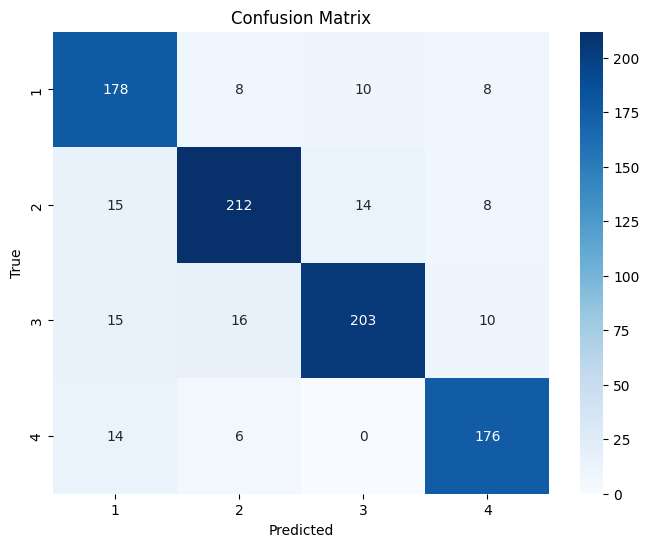

In [89]:
true_labels = filtered_df["Original Answer"]
predicted_labels = filtered_df["Parsed Answer"]

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=[f"Class {c}" for c in sorted(true_labels.unique())])
print("\nClassification Report:")
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(true_labels.unique()), yticklabels=sorted(true_labels.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()